In [1]:
import datetime
import pandas as pd
import pickle
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from ipywidgets import interactive, interact, interactive_output

import ipywidgets as widgets

%matplotlib inline

AFPS = ['HABITAT', 'CUPRUM', 'CAPITAL', 'PLANVITAL', 'PROVIDA', 'MODELO']

#Cargar base de días hábiles
dbpath = r'processed_data/db_habiles.db'
conn_habiles = sqlite3.connect(dbpath)
df_dias_habiles = pd.read_sql('SELECT * FROM HABILES',
                         conn_habiles, parse_dates=['Fecha'])

with open('processed_data/df_new_heroku.pkl', 'rb') as handle:
    data_out = pickle.load(handle)
    
#data_out = pd.read_pickle('processed_data/df_new_heroku.pkl')



def cuadro_rentabilidades(df_valores_cuota, df_dias_habiles):
    
    cols = [c for c in df_valores_cuota.columns if 'V_' in c]
    
    df_aux = fix_fechas(df_valores_cuota, df_dias_habiles)

    aux_data = []
    for serie in cols:
            
        fecha0 = max(df_aux.index.unique()).date()
        fecha_min = min(df_aux.dropna().index.unique()).date()
        days_all = (fecha0 - fecha_min).days
        year0 = fecha0.year
        month0 = fecha0.month
        fechamtd = datetime.datetime(year0, month0, 1).date()
        fechaytd = datetime.datetime(year0, 1, 1).date()
        fecha1y = fecha0 - datetime.timedelta(days=365*1)
        fecha2y = fecha0 - datetime.timedelta(days=365*2)
        fecha3y = fecha0 - datetime.timedelta(days=365*3)
        fecha5y = fecha0 - datetime.timedelta(days=365*5)
        fecha8y = fecha0 - datetime.timedelta(days=365*8)

        rentmtd = df_aux.loc[fecha0][serie] / df_aux.loc[fechamtd][serie] - 1
        rentytd = df_aux.loc[fecha0][serie] / df_aux.loc[fechaytd][serie] - 1
        rent1y = df_aux.loc[fecha0][serie] / df_aux.loc[fecha1y][serie] - 1
        rent2y = (df_aux.loc[fecha0][serie] / df_aux.loc[fecha2y][serie]) ** (1/2) - 1
        rent3y = (df_aux.loc[fecha0][serie] / df_aux.loc[fecha3y][serie]) ** (1/3) - 1
        rent5y = (df_aux.loc[fecha0][serie] / df_aux.loc[fecha5y][serie]) ** (1/5) - 1
        rent8y = (df_aux.loc[fecha0][serie] / df_aux.loc[fecha8y][serie]) ** (1/8) - 1
        rent_all = (df_aux.loc[fecha0][serie] / df_aux.loc[fecha_min][serie]) ** (1/(days_all/365)) - 1
        
        aux_data.append((serie, rentmtd, rentytd, rent1y, rent2y, rent3y, rent5y, rent8y, rent_all))

    df = pd.DataFrame.from_records(aux_data, columns=[
            'Serie', 'Rent MTD', 'Rent YTD', 'Rent 1y', 'Rent 2y', 'Rent 3y', 'Rent 5y', 'Rent 8y', 'Rent All'])

    return df

def fix_fechas(df_valores_cuota, df_dias_habiles):
    
    max_fecha = max(df_valores_cuota['Fecha']).date()
    df_aux = df_valores_cuota.merge(df_dias_habiles[df_dias_habiles['Fecha'].dt.date <= max_fecha], how='outer', on='Fecha')
    df_aux.sort_values('Fecha', inplace=True)
    df_aux.set_index('Fecha', inplace=True)
    df_aux.fillna(method='ffill', inplace=True)
    #df_aux.dropna(inplace=True)
    
    return df_aux

def plot_m(**data):
    
    sel_data = ['Fecha']
    year = data['year']
    
    for serie in [1, 2, 3, 4, 5]:

        if data[f'c_{serie}']:
            afp = data[f'afp_{serie}']
            fondo = data[f'est_{serie}']
            lag = data[f'lag_{serie}']
            str_serie = 'V_{}_{}_lag_{}'.format(afp, fondo, lag)
            sel_data.append(str_serie)
            
        
    plt.figure(2)
    monto_inicial = 100

    df_sel = data_out[year][sel_data]

    df_sel.set_index('Fecha').plot()

    plt.title('Comparador')
    
    plt.show()
    
    df_rent = cuadro_rentabilidades(df_sel.reset_index(), df_dias_habiles)

    cm = sns.diverging_palette(10, 150, sep=60, n=30, as_cmap=True, l=65)

    s = df_rent.style.background_gradient(cmap=cm, axis=0, \
            subset=[c for c in df_rent.columns if 'Rent' in c]).format({
            'Rent MTD': "{:.1%}", 
            'Rent YTD': "{:.1%}", 
            'Rent 1y': "{:.1%}", 
            'Rent 2y': "{:.1%}", 
            'Rent 3y': "{:.1%}", 
            'Rent 5y': "{:.1%}", 
            'Rent 8y': "{:.1%}",
            'Rent All': "{:.1%}"})
    print('')
    print('Tabla de Rentabilidades')
    display(s)

# Parte 1. Comparador de Fondos de Pensiones

Esta aplicación permite comparar la evolución de los fondos de pensiones chilenos, ya sea siguiendo una **estrategia "pasiva"** (vale decir, quedándose en alguno de los fondos A al E), o bien una **estrategia "activa"** (por ejemplo, seguir las recomendaciones de empresas como *Felices y Forrados*).

In [2]:
series = [1, 2, 3, 4, 5]
dict_wid = {}
hboxs = []
for i, serie in enumerate(series):
    if i == 0:
        sel = True
        fondo = 'A'
        lag = 0
    elif i == 1:
        sel = True
        fondo = 'FF'
        lag = 0
    elif i == 2:
        sel = True
        fondo = 'FF'
        lag = 2
    else:
        sel = False
        fondo = 'A'
        lag = 0
    check1 = widgets.Checkbox(
        value=sel,
        description='Serie {}'.format(serie),
        disabled=False,
        indent=False,
        layout=widgets.Layout(width='100px'),
    )
    drop1 = widgets.Dropdown(
        options=AFPS,
        value='HABITAT',
        description='AFP:',
        disabled=False,
    )
    drop2 = widgets.Dropdown(
        options=['A', 'B', 'C', 'D', 'E', 'FF', 'FF_INV', 'MAX'],
        value=fondo,
        description='Estrategia:',
        disabled=False,
    )
    drop3 = widgets.Dropdown(
        options=[0, 1, 2, 3, 4],
        value=lag,
        description='Lag Solicitud:',
        disabled=False,
    )
    
    dict_wid[f'c_{serie}'] = check1
    dict_wid[f'afp_{serie}'] = drop1
    dict_wid[f'est_{serie}'] = drop2
    dict_wid[f'lag_{serie}'] = drop3

    items1 = [check1, drop1, drop2, drop3] 
    hboxs.append(widgets.HBox(items1))

year_wid = widgets.IntSlider(
    value=2012,
    min=2012,
    max=2020,
    step=1,
    description='Año de Inicio:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
    
dict_wid['year'] = year_wid
hboxs.append(year_wid)

out = interactive_output(plot_m, dict_wid)

ui = widgets.VBox(hboxs)

accordion = widgets.Accordion(children=[ui])
accordion.set_title(0, 'Seleccione')

display(accordion, out)

Accordion(children=(VBox(children=(HBox(children=(Checkbox(value=True, description='Serie 1', indent=False, la…

Output()

## NOTAS

1. Rentabilidades presentadas son anualizadas (salvo MTD y YTD).

2. Para asegurar la comparabilidad en el tiempo, se asume que las personas hacen una única inversión en una fecha de inicio determinada y siguiendo una estrategia determinada. (*Un ejercicio más realista debería incorporar información de aportes (o retiros) mensuales y comisiones, pero quedará fuera del ámbito de este proyecto por el momento. En todo caso, las conclusiones principales no deberían ser afectadas por estos elementos.*).

3. Parámetros relevantes:
    - **Estrategia**: Se refiere a una estrategia pasiva (dejar dinero en fondo A al E), o una estrategia activa (*FF* sería seguir las recomendaciones de Felices y Forrados). Estrategia "MAX" es una estrategia que al inicio de cada mes elije el fondo que tendrá más rentabilidad ese mes.
    - **Lag Solicitud**: Se refiere al rezago que existe entre el momento en que se realiza la sugerencia de cambio de fondo y el momento en que la persona solicita el cambio de fondo. Por ejemplo, un Lag=2 significa que la persona se demora 2 días en solicitar formalmente el cambio de fondo a su AFP.

4. Para agregar más series al comparador, debe seleccionar la casilla **"Serie"** al costado izquierdo.

5. Más antecedentes sobre los procesos detrás de la aplicación [AQUÍ](https://github.com/calvarad/fyf).

# Parte 2. Comparador de rentabilidades

interactive(children=(IntSlider(value=3, description='años_de_horizonte', max=6, min=1), Dropdown(description=…

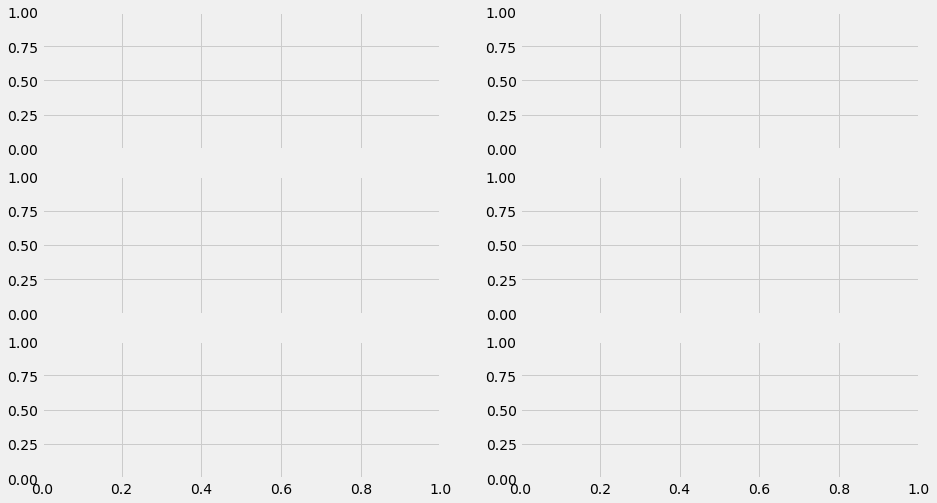

In [1]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pickle

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.style.use("fivethirtyeight")
import sys
sys.path.append("../")
from src import compare_afp_with_ff_distributions


with open('processed_data/horizonte_de_tiempo_data_dict.pickle', 'rb') as handle:
    afp_año_dict = pickle.load(handle)

def fetch_data_and_plot(años_de_horizonte: int, afp: str, lag_fyf):
    results = afp_año_dict[afp][años_de_horizonte]
    return compare_afp_with_ff_distributions(results, años_de_horizonte, afp, 
                                  lag_solicitud_afp=0, lag_solicitud_ff=lag_fyf,
                                      figsize=(14, 8))
    
lista_afps = ['CAPITAL', 'CUPRUM', 'HABITAT', 'PLANVITAL', 'PROVIDA', 'MODELO']

posibles_años = widgets.IntSlider(min=1, max=6, step=1, value=3)
posibles_afps = widgets.Dropdown(
    options=lista_afps,
    value='CAPITAL',
    description='AFP:',
)
posibles_lags = widgets.IntSlider(min=0, max=4, step=1, value=2)

interact(fetch_data_and_plot, años_de_horizonte=posibles_años,
        afp=posibles_afps, lag_fyf=posibles_lags);